In [1]:
## for comet
#from comet_ml import Experiment

import numpy
from tqdm import tqdm
from collections import OrderedDict
from dataset import ptb
import sys
import os
import pickle
import random
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
#device = 'cpu'
device = 'gpu'

np = numpy
if device == 'gpu':
    import cupy
    import cupyx
    np = cupy
print(f'Use {device}.')

Use gpu.


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, ndim=-1):
    x = x.astype('float64')
    if x.ndim == -1:
        ndim = len(x.shape) - 1
    c = x.max()
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x, axis=ndim)
    out = (exp_x.T / sum_exp_x).T
    return out.astype('f')

def cross_entropy_error(y, t, onehot=False):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    if not onehot:
        out = -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    else:
        out = -np.sum(np.dot(t, np.log(y + 1e-7))) / batch_size
    return out

def numerical_diff(f, x, i):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_diff2(f, x, i, j):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i, j] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_gradient(f, x):
    grad = np.zeros_like(x).astype(np.float128)
    n, m = x.shape
    for i in range(n):
        for j in range(m):
            grad[i, j] = numerical_diff2(f, x, i, j)
    return grad

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def to_cpu(x):
    if type(x) == numpy.ndarray:
        return x
    return cupy.asnumpy(x)

def to_gpu(x):
    if type(x) == cupy.ndarray:
        return x
    return cupy.array(x)

def to_device(x, device=device):
    if device == 'gpu':
        return to_gpu(x)
    else:
        return to_cpu(x)

In [4]:
class Adam:
    def __init__(self, shape, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0

    def update(self, w, dw):
        self.t += 1
        self.m = (self.beta1 * self.m) + (1 - self.beta1) * dw
        self.v = (self.beta2 * self.v) + (1 - self.beta2) * dw**2
        mh = self.m / (1 - self.beta1 ** self.t)
        vh = self.v / (1 - self.beta2 ** self.t)
        w -= self.alpha * (mh / (np.sqrt(vh) + self.epsilon))

class AdamContainer:
    def __init__(self, layers, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.params = []
        for params in [layer.params for layer in layers]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in layers]:
            for grad in grads:
                self.grads.append(grad)
        self.adams = [Adam(param.shape, alpha, beta1, beta2, epsilon) for param in self.params]
    
    def update(self):
        for adam, param, grad in zip(self.adams, self.params, self.grads):
            adam.update(param, grad)

In [5]:
class BaseLayer:
    def __init__(self):
        self.params = None
        self.grads = None
        
    def to_cpu(self):
        for param in self.params:
            param = to_cpu(param)
        for grad in self.grads:
            grad = to_cpu(grad)
            
    def to_gpu(self):
        for param in self.params:
            param = to_gpu(param)
        for grad in self.grads:
            grad = to_gpu(grad)

class Affine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
    
    def forward(self, x):
        w, b = self.params
        self.x = x
        return np.dot(x, w) + b
    
    def backward(self, dout):
        w = self.params[0]
        dx = np.dot(dout, w.T)
        self.grads[0] = self.dw = np.dot(self.x.T, dout)
        self.grads[1] = self.db = np.sum(dout, axis=0)
        return dx

class TimeAffine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
        self.layers = None
        self.cache = None
        
    def forward(self, xs):
        w, b = self.params
        N, T, D = xs.shape
        D, V = w.shape
        
        out = np.empty((N, T, V), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Affine(w, b)
            out[:,t,:] = layer.forward(xs[:,t,:])
            self.layers.append(layer)
        
        self.cache = (N, T, D, V)
        return out
    
    def backward(self, dout):
        N, T, D, V = self.cache
        
        out = np.empty((N, T, D), dtype='f')
        dw = np.empty((D, T, V), dtype='f')
        db = np.empty((T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            out[:,t,:] = layer.backward(dout[:,t,:])
            dw[:,t,:] = layer.dw
            db[t,:] = layer.db
        self.grads[0] = self.dw = dw.sum(axis=1)
        self.grads[1] = self.db = db.sum(axis=0)
        
        return out

class ReLU(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class Sigmoid(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx
    
class Softmax(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.y = softmax(x)
        return self.y
    
    def backward(self, dout):
        dx = self.y * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.y * sumdx
        return dx

class SoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1, onehot=False):
        batch_size = self.t.shape[0]
        if not onehot:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx *= dout
            dx = dx / batch_size
        else:
            dx = (self.y - self.t) / batch_size
        return dx

class TimeSoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.layers = None
        self.cache = None
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        # if ts is one-hot vector
        if ts.ndim == 3:
            ts = ts.argmax(axis=2).reshape(N, T)
        
        ys = np.empty(T, dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = SoftmaxWithLoss()
            ys[t] = layer.forward(xs[:,t,:], ts[:,t])
            self.layers.append(layer)
            
        loss = ys.sum() / T
        
        self.cache = (N, T, V)
        return loss
    
    def backward(self):
        N, T, V = self.cache
        dx = np.empty((N, T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            dx[:,t,:] = layer.backward()
        self.dx = dx / T
        
        return self.dx

class Dropout(BaseLayer):
    def __init__(self, ratio=0.5):
        self.params = []
        self.grads = []
        self.ratio = ratio
        self.mask = None
        self.train = True

    def forward(self, x):
        if self.train:
            self.mask = np.random.rand(*x.shape) > self.ratio
            self.mask = self.mask.astype('f') / (1.0 - self.ratio)
            return x * self.mask
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

class Embedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.idx = None
        
    def forward(self, idx):
        w = self.params[0]
        self.idx = idx
        return w[idx]
    
    def backward(self, dout):
        if device == 'gpu':
            add_at = cupyx.scatter_add
        else:
            add_at = np.add.at
            
        dw = self.grads[0]
        dw[...] = 0
        add_at(dw, self.idx, dout)
        self.grads[0] = self.dw = dw
        return None

class TimeEmbedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.layers = None
        
    def forward(self, xs):
        w = self.params[0]
        N, T = xs.shape
        V, D = w.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(w)
            out[:,t,:] = layer.forward(xs[:,t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        dw = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:,t,:])
            dw += layer.dw
        self.grads[0] = self.dw = dw
        
        return None

class RNN(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
    
    def forward(self, x, h_prev):
        wx, wh, b = self.params
        t = np.dot(h_prev, wh) + np.dot(x, wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        wx, wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - dh_next ** 2)
        db = np.sum(dt, axis=0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, wh.T)
        dwx = np.dot(x.T, dt)
        dx = np.dot(dt, wx.T)
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev

class TimeRNN(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        D, H = wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:], self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D, H = wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class LSTM(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        wx, wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(h_prev, wh) + np.dot(x, wx) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev,i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        wx, wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= 1 - g ** 2
        
        dA = np.hstack((df, dg, di, do))
        
        dwh = np.dot(h_prev.T, dA)
        dh_prev = np.dot(dA, wh.T)
        dwx = np.dot(x.T, dA)
        dx = np.dot(dA, wx.T)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev, dc_prev

class TimeLSTM(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh, self.c = None, None, None
        self.stateful = stateful
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        H = wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D = wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class BaseNetwork:
    def __init__(self):
        self.layers = None
        self.lastLayer = None
        self.adam = None
        
    def train(self, x, t):
        # forward
        loss = self.loss(x, t)
        
        # backward
        dout = self.lastLayer.backward()
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        self.update()
            
        return loss
    
    def update(self):
        for grads in [layer.grads for layer in self.layers.values()]:
            clip_grads(grads, self.max_grad)
        self.adam.update()
    
    def save(self, state_file_name = 'network.state.pkl'):
        params = self.adam.params.copy()
        for i, param in enumerate(params):
            params[i] = to_cpu(params[i])
            
        with open(state_file_name, 'wb') as f:
            pickle.dump(params, f)
            print(f'Saved: {state_file_name}')
            
    def load(self, state_file_name = 'network.state.pkl'):
        if os.path.exists(state_file_name):
            with open(state_file_name, 'rb') as f:
                params = pickle.load(f)
                for i, param in enumerate(params):
                    self.adam.params[i][:] = to_device(param, device)
                print(f'Loaded: {state_file_name}')

In [6]:
class Encoder(BaseLayer):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['LSTM'] = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=False)
        
        self.params = []
        for params in [layer.params for layer in self.layers.values()]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in self.layers.values()]:
            for grad in grads:
                self.grads.append(grad)
        self.hs = None
        
    def forward(self, xs):
        for layer in self.layers.values():
            xs = layer.forward(xs)
        self.hs = xs
        return xs[:,-1,:]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:,-1,:] = dh
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dhs = layer.backward(dhs)
        return dhs

In [7]:
class Decoder(BaseLayer):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_w = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['LSTM'] = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=True)
        self.layers['Affine'] = TimeAffine(affine_w, affine_b)
        
        self.params = []
        for params in [layer.params for layer in self.layers.values()]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in self.layers.values()]:
            for grad in grads:
                self.grads.append(grad)
        
    def forward(self, xs, h):
        self.layers['LSTM'].set_state(h)
        for layer in self.layers.values():
            xs = layer.forward(xs)
        return xs
    
    def backward(self, dh):
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dh = layer.backward(dh)
        return self.layers['LSTM'].dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.layers['LSTM'].set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            for layer in self.layers.values():
                x = layer.forward(x)
            sample_id = np.argmax(x.flatten())
            sampled.append(int(sample_id))

        return np.array(sampled)

class PeekyDecoder(BaseLayer):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(H + D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_w = (rn(H + H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['LSTM'] = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=True)
        self.layers['Affine'] = TimeAffine(affine_w, affine_b)
        
        self.params = []
        for params in [layer.params for layer in self.layers.values()]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in self.layers.values()]:
            for grad in grads:
                self.grads.append(grad)
        self.cache = None
        
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.layers['LSTM'].set_state(h)
        
        out = self.layers['Embedding'].forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)
        
        out = self.layers['LSTM'].forward(out)
        out = np.concatenate((hs, out), axis=2)
        
        score = self.layers['Affine'].forward(out)
        self.cache = H
        return score
    
    def backward(self, dh):
        H = self.cache
        
        dout = self.layers['Affine'].backward(dh)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        
        dout = self.layers['LSTM'].backward(dout)
        dout, dhs1 = dout[:, :, H:], dout[:, :, :H]
        
        self.layers['Embedding'].backward(dout)

        dhs = dhs0 + dhs1
        dh = self.layers['LSTM'].dh + np.sum(dhs, axis=1)
        
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.layers['LSTM'].set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1)
            out = self.layers['Embedding'].forward(x)
            out = np.concatenate((peeky_h, out), axis=2)
            out = self.layers['LSTM'].forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.layers['Affine'].forward(out)
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return np.array(sampled)

class Seq2SeqNetwork(BaseNetwork):
    def __init__(self, vocab_size, wordvec_size, hidden_size, max_grad=5.0):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.max_grad = max_grad
        self.layers = OrderedDict()
        self.layers['Encoder'] = Encoder(V, D, H)
        self.layers['Decoder'] = PeekyDecoder(V, D, H)
        self.lastLayer = TimeSoftmaxWithLoss()
        self.adam = AdamContainer(list(self.layers.values()))
        
    def generate(self, xs, start_id, sample_size):
        h = self.layers['Encoder'].forward(xs)
        sampled = self.layers['Decoder'].generate(h, start_id, sample_size)
        return sampled
        
    def loss(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.layers['Encoder'].forward(xs)
        score = self.layers['Decoder'].forward(decoder_xs, h)
        loss = self.lastLayer.forward(score, decoder_ts)
        return loss

In [8]:
def generate_question():
    num1 = random.randint(0, 999)
    num2 = random.randint(0, 999)
    question = str(num1) + '+' + str(num2)
    correct = '=' + str(num1 + num2)
    question = question.ljust(7)
    correct = correct.ljust(5+1)
    return question, correct

def make_question_data(data_size, char_to_id):
    questions = []
    corrects = []
    for _ in range(data_size):
        q, c = generate_question()
        q = [char_to_id[s] for s in q]
        c = [char_to_id[s] for s in c]
        questions.append(q)
        corrects.append(c)
    questions = np.array(questions)
    corrects = np.array(corrects)
    return questions[:, ::-1], corrects

In [9]:
class Program2:
    def __init__(self):
        self.char_to_id = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '+':10, '=':11, ' ':12}
        self.id_to_char = dict(zip(self.char_to_id.values(), self.char_to_id.keys()))
        self.params = OrderedDict({'vocab_size': len(self.char_to_id), 'wordvec_size': 16, 'hidden_size': 256,
                                   'max_grad': 5.0, 'max_epoch': 100, 'sample_size': 50000, 'batch_size': 128})
        self.losses = []
        
    def fit(self, x, t, batch_size):
        data_size = len(x)
        max_iters = data_size // batch_size
        
        for iters in tqdm(range(max_iters)):
            batch_x = x[iters*batch_size:(iters+1)*batch_size]
            batch_t = t[iters*batch_size:(iters+1)*batch_size]

            loss = self.net.train(batch_x, batch_t)
            self.losses.append(loss.tolist())
            
        return loss
        
    def __call__(self):
        ## for comet
        #experiment = Experiment()
        #experiment.log_parameters(self.params)
        
        for key in self.params.keys() :
            print(f'{key}: {self.params[key]}')
        vocab_size, wordvec_size, hidden_size, max_grad, max_epoch, sample_size, batch_size = self.params.values()

        self.net = Seq2SeqNetwork(vocab_size, wordvec_size, hidden_size, max_grad)
        self.net.load()
        
        if sample_size != -1:
            questions, corrects = make_question_data(sample_size, self.char_to_id)
            
        for epoch in range(max_epoch):
            if sample_size == -1:
                questions, corrects = make_question_data(batch_size, self.char_to_id)
            loss = self.fit(questions, corrects, batch_size)
            
            correct_num = 0
            test_num = 3
            for _ in range(test_num):
                test_q, test_c = make_question_data(1, self.char_to_id)
                answer = self.net.generate(test_q, start_id=self.char_to_id['='], sample_size=4)
                question = ''.join([self.id_to_char[x] for x in to_cpu(test_q[0, ::-1])])
                correct = ''.join([self.id_to_char[x] for x in to_cpu(test_c[0, 1:-1])])
                answer = ''.join([self.id_to_char[x] for x in to_cpu(answer)])
                is_correct = True if answer == correct else False
                correct_num += 1 if is_correct else 0
                print(f'{"○" if is_correct else "×"} {question} = {answer}[{correct}]')
            print(f'[{epoch}] Corrects {correct_num} / {test_num}\tloss: {loss}')
            
            ## for comet
            #experiment.log_metric('loss', loss, step=epoch)
        
        self.net.save()
        self.exam()

        ## for comet
        #experiment.end()
    
    def exam(self, question_num=100):
        correct_num = 0
        questions, corrects = make_question_data(question_num, self.char_to_id)
        for i in range(question_num):
            answer = self.net.generate(np.expand_dims(questions[i], axis=0), start_id=self.char_to_id['='], sample_size=4)
            question = ''.join([self.id_to_char[x] for x in to_cpu(questions[i, ::-1])])
            correct = ''.join([self.id_to_char[x] for x in to_cpu(corrects[i, 1:-1])])
            answer = ''.join([self.id_to_char[x] for x in to_cpu(answer)])
            is_correct = True if answer == correct else False
            correct_num += 1 if is_correct else 0
            print(f'{"○" if is_correct else "×"} {question} = {answer}[{correct}]')
        print(f'Score: {correct_num} / {question_num}\tAccuracy: {(correct_num / question_num)}')

In [10]:
program = Program2()
if __name__ == '__main__':
    program()

vocab_size: 13
wordvec_size: 16
hidden_size: 256
max_grad: 5.0
max_epoch: 100
sample_size: 50000
batch_size: 128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:08<00:00, 45.11it/s]


× 497+701 = 1022[1198]
× 574+905 = 1112[1479]
× 429+20  = 102 [449 ]
[0] Corrects 0 / 3	loss: 1.4774787425994873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:08<00:00, 44.89it/s]


× 487+890 = 1222[1377]
× 481+589 = 1022[1070]
× 213+574 = 1002[787 ]
[1] Corrects 0 / 3	loss: 1.4219539165496826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:08<00:00, 43.75it/s]


× 598+718 = 1002[1316]
× 744+238 = 1002[982 ]
× 638+153 = 1004[791 ]
[2] Corrects 0 / 3	loss: 1.3948949575424194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 42.37it/s]


× 196+208 = 649 [404 ]
× 503+121 = 584 [624 ]
× 311+264 = 549 [575 ]
[3] Corrects 0 / 3	loss: 1.3035507202148438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.19it/s]


× 224+910 = 1122[1134]
× 524+410 = 105 [934 ]
× 243+318 = 649 [561 ]
[4] Corrects 0 / 3	loss: 1.2680461406707764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.32it/s]


× 503+242 = 744 [745 ]
× 72+974  = 900 [1046]
× 987+115 = 1122[1102]
[5] Corrects 0 / 3	loss: 1.1763606071472168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.19it/s]


× 279+109 = 477 [388 ]
○ 668+376 = 1044[1044]
× 950+414 = 1390[1364]
[6] Corrects 1 / 3	loss: 1.063449740409851


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.78it/s]


× 99+51   = 100 [150 ]
× 738+336 = 1044[1074]
× 432+973 = 1315[1405]
[7] Corrects 0 / 3	loss: 0.9656214714050293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.30it/s]


× 766+442 = 1118[1208]
○ 924+464 = 1388[1388]
× 415+672 = 1077[1087]
[8] Corrects 1 / 3	loss: 0.8595948219299316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.41it/s]


○ 553+469 = 1022[1022]
× 823+817 = 1550[1640]
× 724+915 = 1559[1639]
[9] Corrects 1 / 3	loss: 0.792756199836731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.97it/s]


× 531+155 = 676 [686 ]
× 94+492  = 646 [586 ]
× 243+556 = 899 [799 ]
[10] Corrects 0 / 3	loss: 0.7306767702102661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.53it/s]


○ 535+453 = 988 [988 ]
× 273+186 = 489 [459 ]
× 752+860 = 1512[1612]
[11] Corrects 1 / 3	loss: 0.6493179202079773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.29it/s]


× 478+312 = 890 [790 ]
× 496+541 = 1137[1037]
○ 665+144 = 809 [809 ]
[12] Corrects 1 / 3	loss: 0.6138715744018555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.57it/s]


○ 895+727 = 1622[1622]
× 482+190 = 662 [672 ]
○ 858+183 = 1041[1041]
[13] Corrects 2 / 3	loss: 0.5510691404342651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.13it/s]


× 363+933 = 1396[1296]
× 3+451   = 145 [454 ]
× 79+290  = 388 [369 ]
[14] Corrects 0 / 3	loss: 0.500867486000061


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.25it/s]


○ 129+980 = 1109[1109]
○ 964+530 = 1494[1494]
○ 878+496 = 1374[1374]
[15] Corrects 3 / 3	loss: 0.45857882499694824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.22it/s]


○ 272+371 = 643 [643 ]
○ 520+954 = 1474[1474]
○ 414+548 = 962 [962 ]
[16] Corrects 3 / 3	loss: 0.4263331890106201


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.25it/s]


○ 264+628 = 892 [892 ]
○ 663+853 = 1516[1516]
× 367+188 = 655 [555 ]
[17] Corrects 2 / 3	loss: 0.3972957730293274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.98it/s]


× 879+822 = 1601[1701]
× 0+116   = 222 [116 ]
○ 954+265 = 1219[1219]
[18] Corrects 1 / 3	loss: 0.3796938359737396


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 41.05it/s]


○ 647+64  = 711 [711 ]
○ 460+97  = 557 [557 ]
○ 718+221 = 939 [939 ]
[19] Corrects 3 / 3	loss: 0.36229902505874634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.33it/s]


○ 622+172 = 794 [794 ]
○ 781+489 = 1270[1270]
× 992+709 = 1791[1701]
[20] Corrects 2 / 3	loss: 0.3449919819831848


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.52it/s]


○ 923+379 = 1302[1302]
× 272+768 = 1030[1040]
○ 854+834 = 1688[1688]
[21] Corrects 2 / 3	loss: 0.348852276802063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.79it/s]


× 215+81  = 396 [296 ]
× 236+356 = 692 [592 ]
○ 861+631 = 1492[1492]
[22] Corrects 1 / 3	loss: 0.30580323934555054


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.85it/s]


○ 575+370 = 945 [945 ]
○ 616+49  = 665 [665 ]
× 13+655  = 678 [668 ]
[23] Corrects 2 / 3	loss: 0.2941296696662903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.30it/s]


○ 517+450 = 967 [967 ]
× 300+512 = 712 [812 ]
× 992+858 = 1750[1850]
[24] Corrects 1 / 3	loss: 0.2872253656387329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.63it/s]


○ 270+468 = 738 [738 ]
○ 719+242 = 961 [961 ]
○ 432+737 = 1169[1169]
[25] Corrects 3 / 3	loss: 0.26607441902160645


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.58it/s]


○ 302+364 = 666 [666 ]
× 133+52  = 385 [185 ]
○ 288+407 = 695 [695 ]
[26] Corrects 2 / 3	loss: 0.25834372639656067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.86it/s]


○ 350+752 = 1102[1102]
○ 715+525 = 1240[1240]
○ 716+561 = 1277[1277]
[27] Corrects 3 / 3	loss: 0.24956460297107697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.23it/s]


○ 491+485 = 976 [976 ]
○ 662+547 = 1209[1209]
○ 370+485 = 855 [855 ]
[28] Corrects 3 / 3	loss: 0.24167558550834656


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.11it/s]


○ 840+494 = 1334[1334]
○ 536+884 = 1420[1420]
○ 876+363 = 1239[1239]
[29] Corrects 3 / 3	loss: 0.23188337683677673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.01it/s]


○ 581+50  = 631 [631 ]
○ 668+479 = 1147[1147]
○ 994+742 = 1736[1736]
[30] Corrects 3 / 3	loss: 0.22802221775054932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.78it/s]


○ 899+770 = 1669[1669]
○ 940+467 = 1407[1407]
○ 736+562 = 1298[1298]
[31] Corrects 3 / 3	loss: 0.22739291191101074


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.74it/s]


○ 212+57  = 269 [269 ]
○ 830+507 = 1337[1337]
× 78+718  = 816 [796 ]
[32] Corrects 2 / 3	loss: 0.21637777984142303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.84it/s]


○ 107+425 = 532 [532 ]
× 23+965  = 998 [988 ]
○ 484+758 = 1242[1242]
[33] Corrects 2 / 3	loss: 0.21014969050884247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.36it/s]


○ 658+799 = 1457[1457]
○ 999+856 = 1855[1855]
○ 534+229 = 763 [763 ]
[34] Corrects 3 / 3	loss: 0.2222270518541336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.62it/s]


○ 789+475 = 1264[1264]
○ 525+496 = 1021[1021]
○ 907+580 = 1487[1487]
[35] Corrects 3 / 3	loss: 0.19005276262760162


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.66it/s]


○ 486+975 = 1461[1461]
○ 226+374 = 600 [600 ]
○ 562+411 = 973 [973 ]
[36] Corrects 3 / 3	loss: 0.18645413219928741


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.78it/s]


○ 792+478 = 1270[1270]
○ 374+888 = 1262[1262]
○ 414+789 = 1203[1203]
[37] Corrects 3 / 3	loss: 0.19039727747440338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.82it/s]


○ 751+110 = 861 [861 ]
× 36+17   = 13  [53  ]
○ 412+483 = 895 [895 ]
[38] Corrects 2 / 3	loss: 0.19613198935985565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.80it/s]


○ 483+806 = 1289[1289]
○ 207+914 = 1121[1121]
○ 948+529 = 1477[1477]
[39] Corrects 3 / 3	loss: 0.17321209609508514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.66it/s]


○ 748+213 = 961 [961 ]
○ 843+652 = 1495[1495]
○ 432+77  = 509 [509 ]
[40] Corrects 3 / 3	loss: 0.17423424124717712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.67it/s]


○ 711+994 = 1705[1705]
× 91+399  = 470 [490 ]
○ 208+15  = 223 [223 ]
[41] Corrects 2 / 3	loss: 0.1780482530593872


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.74it/s]


○ 121+324 = 445 [445 ]
○ 465+86  = 551 [551 ]
○ 300+187 = 487 [487 ]
[42] Corrects 3 / 3	loss: 0.16369707882404327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.07it/s]


○ 200+743 = 943 [943 ]
○ 935+356 = 1291[1291]
○ 110+863 = 973 [973 ]
[43] Corrects 3 / 3	loss: 0.15797558426856995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.28it/s]


○ 828+777 = 1605[1605]
○ 456+808 = 1264[1264]
○ 360+304 = 664 [664 ]
[44] Corrects 3 / 3	loss: 0.16132524609565735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.04it/s]


○ 417+113 = 530 [530 ]
○ 859+447 = 1306[1306]
○ 971+256 = 1227[1227]
[45] Corrects 3 / 3	loss: 0.1530684530735016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.00it/s]


○ 514+741 = 1255[1255]
○ 151+728 = 879 [879 ]
○ 444+358 = 802 [802 ]
[46] Corrects 3 / 3	loss: 0.17374292016029358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.28it/s]


× 109+151 = 360 [260 ]
○ 991+92  = 1083[1083]
○ 187+963 = 1150[1150]
[47] Corrects 2 / 3	loss: 0.15126895904541016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.75it/s]


○ 273+833 = 1106[1106]
○ 248+668 = 916 [916 ]
○ 352+649 = 1001[1001]
[48] Corrects 3 / 3	loss: 0.14712095260620117


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.12it/s]


○ 74+348  = 422 [422 ]
○ 814+788 = 1602[1602]
○ 814+986 = 1800[1800]
[49] Corrects 3 / 3	loss: 0.14758172631263733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.45it/s]


○ 372+293 = 665 [665 ]
○ 930+515 = 1445[1445]
○ 13+22   = 35  [35  ]
[50] Corrects 3 / 3	loss: 0.13714565336704254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.96it/s]


○ 166+900 = 1066[1066]
○ 168+332 = 500 [500 ]
○ 768+294 = 1062[1062]
[51] Corrects 3 / 3	loss: 0.14324969053268433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.91it/s]


○ 926+934 = 1860[1860]
× 2+738   = 640 [740 ]
○ 995+401 = 1396[1396]
[52] Corrects 2 / 3	loss: 0.13195039331912994


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.08it/s]


○ 142+894 = 1036[1036]
○ 748+890 = 1638[1638]
○ 444+657 = 1101[1101]
[53] Corrects 3 / 3	loss: 0.1311648190021515


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.19it/s]


○ 614+577 = 1191[1191]
○ 526+353 = 879 [879 ]
○ 656+749 = 1405[1405]
[54] Corrects 3 / 3	loss: 0.13003161549568176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.80it/s]


○ 489+830 = 1319[1319]
○ 848+861 = 1709[1709]
○ 746+323 = 1069[1069]
[55] Corrects 3 / 3	loss: 0.13425356149673462


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.79it/s]


○ 172+222 = 394 [394 ]
○ 155+483 = 638 [638 ]
○ 959+222 = 1181[1181]
[56] Corrects 3 / 3	loss: 0.1320599615573883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.47it/s]


○ 212+801 = 1013[1013]
○ 101+175 = 276 [276 ]
○ 113+131 = 244 [244 ]
[57] Corrects 3 / 3	loss: 0.12846185266971588


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.05it/s]


○ 938+984 = 1922[1922]
○ 965+650 = 1615[1615]
○ 385+596 = 981 [981 ]
[58] Corrects 3 / 3	loss: 0.11810829490423203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.04it/s]


○ 630+267 = 897 [897 ]
○ 556+552 = 1108[1108]
○ 254+914 = 1168[1168]
[59] Corrects 3 / 3	loss: 0.1172235980629921


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.00it/s]


○ 643+529 = 1172[1172]
○ 888+881 = 1769[1769]
○ 860+391 = 1251[1251]
[60] Corrects 3 / 3	loss: 0.15614967048168182


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.56it/s]


○ 958+848 = 1806[1806]
× 98+521  = 629 [619 ]
○ 721+915 = 1636[1636]
[61] Corrects 2 / 3	loss: 0.12397316843271255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.88it/s]


○ 947+15  = 962 [962 ]
○ 200+473 = 673 [673 ]
○ 428+945 = 1373[1373]
[62] Corrects 3 / 3	loss: 0.11375454813241959


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.48it/s]


○ 923+87  = 1010[1010]
○ 450+33  = 483 [483 ]
○ 853+213 = 1066[1066]
[63] Corrects 3 / 3	loss: 0.11081725358963013


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.05it/s]


○ 866+46  = 912 [912 ]
× 454+147 = 501 [601 ]
○ 639+300 = 939 [939 ]
[64] Corrects 2 / 3	loss: 0.12586338818073273


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.67it/s]


○ 501+792 = 1293[1293]
○ 628+264 = 892 [892 ]
○ 909+561 = 1470[1470]
[65] Corrects 3 / 3	loss: 0.10782359540462494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.55it/s]


○ 23+189  = 212 [212 ]
○ 194+254 = 448 [448 ]
○ 73+663  = 736 [736 ]
[66] Corrects 3 / 3	loss: 0.10625286400318146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.74it/s]


○ 361+79  = 440 [440 ]
○ 942+212 = 1154[1154]
○ 16+142  = 158 [158 ]
[67] Corrects 3 / 3	loss: 0.11434928327798843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.56it/s]


○ 686+580 = 1266[1266]
○ 919+703 = 1622[1622]
○ 719+942 = 1661[1661]
[68] Corrects 3 / 3	loss: 0.10339125245809555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 40.37it/s]


○ 173+251 = 424 [424 ]
○ 985+786 = 1771[1771]
○ 822+41  = 863 [863 ]
[69] Corrects 3 / 3	loss: 0.10159305483102798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.57it/s]


○ 625+251 = 876 [876 ]
○ 709+721 = 1430[1430]
○ 560+996 = 1556[1556]
[70] Corrects 3 / 3	loss: 0.10077480226755142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.44it/s]


○ 818+659 = 1477[1477]
○ 440+224 = 664 [664 ]
○ 255+850 = 1105[1105]
[71] Corrects 3 / 3	loss: 0.13802431523799896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.30it/s]


○ 650+877 = 1527[1527]
○ 185+508 = 693 [693 ]
○ 127+183 = 310 [310 ]
[72] Corrects 3 / 3	loss: 0.09791173040866852


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.15it/s]


○ 182+864 = 1046[1046]
○ 207+475 = 682 [682 ]
○ 439+439 = 878 [878 ]
[73] Corrects 3 / 3	loss: 0.09704922139644623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.39it/s]


○ 263+400 = 663 [663 ]
○ 164+741 = 905 [905 ]
○ 194+796 = 990 [990 ]
[74] Corrects 3 / 3	loss: 0.09884200990200043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.86it/s]


○ 941+678 = 1619[1619]
○ 766+791 = 1557[1557]
○ 171+80  = 251 [251 ]
[75] Corrects 3 / 3	loss: 0.09337300062179565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.27it/s]


○ 907+176 = 1083[1083]
○ 477+5   = 482 [482 ]
○ 590+799 = 1389[1389]
[76] Corrects 3 / 3	loss: 0.11121807992458344


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.63it/s]


○ 833+463 = 1296[1296]
○ 157+783 = 940 [940 ]
○ 241+355 = 596 [596 ]
[77] Corrects 3 / 3	loss: 0.09454415738582611


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.18it/s]


× 91+195  = 276 [286 ]
○ 344+161 = 505 [505 ]
○ 986+205 = 1191[1191]
[78] Corrects 2 / 3	loss: 0.09245423972606659


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.41it/s]


○ 928+569 = 1497[1497]
○ 940+151 = 1091[1091]
○ 151+215 = 366 [366 ]
[79] Corrects 3 / 3	loss: 0.09058817476034164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.46it/s]


○ 564+422 = 986 [986 ]
○ 710+126 = 836 [836 ]
○ 944+66  = 1010[1010]
[80] Corrects 3 / 3	loss: 0.10852702707052231


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.07it/s]


○ 577+666 = 1243[1243]
○ 525+817 = 1342[1342]
○ 356+851 = 1207[1207]
[81] Corrects 3 / 3	loss: 0.10098092257976532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.98it/s]


○ 950+599 = 1549[1549]
○ 683+523 = 1206[1206]
○ 464+316 = 780 [780 ]
[82] Corrects 3 / 3	loss: 0.0903182104229927


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.77it/s]


○ 815+402 = 1217[1217]
○ 880+856 = 1736[1736]
○ 913+720 = 1633[1633]
[83] Corrects 3 / 3	loss: 0.08788476139307022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.28it/s]


○ 505+824 = 1329[1329]
○ 624+923 = 1547[1547]
○ 27+884  = 911 [911 ]
[84] Corrects 3 / 3	loss: 0.09649576246738434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.23it/s]


○ 884+685 = 1569[1569]
○ 966+575 = 1541[1541]
○ 914+320 = 1234[1234]
[85] Corrects 3 / 3	loss: 0.08782421797513962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.30it/s]


○ 53+940  = 993 [993 ]
○ 331+328 = 659 [659 ]
○ 326+93  = 419 [419 ]
[86] Corrects 3 / 3	loss: 0.09439194947481155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.60it/s]


× 5+588   = 588 [593 ]
○ 184+254 = 438 [438 ]
○ 226+303 = 529 [529 ]
[87] Corrects 2 / 3	loss: 0.08581797778606415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.44it/s]


○ 925+63  = 988 [988 ]
○ 411+424 = 835 [835 ]
○ 102+228 = 330 [330 ]
[88] Corrects 3 / 3	loss: 0.08438146859407425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.07it/s]


○ 940+294 = 1234[1234]
○ 271+882 = 1153[1153]
○ 655+323 = 978 [978 ]
[89] Corrects 3 / 3	loss: 0.09535884857177734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.39it/s]


○ 539+803 = 1342[1342]
○ 549+481 = 1030[1030]
○ 540+548 = 1088[1088]
[90] Corrects 3 / 3	loss: 0.08538176119327545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.01it/s]


× 410+6   = 426 [416 ]
○ 36+607  = 643 [643 ]
× 74+36   = 100 [110 ]
[91] Corrects 1 / 3	loss: 0.08238285034894943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.38it/s]


○ 550+805 = 1355[1355]
○ 612+798 = 1410[1410]
○ 844+19  = 863 [863 ]
[92] Corrects 3 / 3	loss: 0.08145488798618317


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.18it/s]


○ 929+773 = 1702[1702]
○ 527+646 = 1173[1173]
○ 422+970 = 1392[1392]
[93] Corrects 3 / 3	loss: 0.10169687122106552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.71it/s]


○ 208+265 = 473 [473 ]
○ 903+949 = 1852[1852]
○ 261+248 = 509 [509 ]
[94] Corrects 3 / 3	loss: 0.08505451679229736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.29it/s]


○ 599+188 = 787 [787 ]
○ 102+677 = 779 [779 ]
○ 641+513 = 1154[1154]
[95] Corrects 3 / 3	loss: 0.07986775040626526


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.46it/s]


○ 261+626 = 887 [887 ]
○ 356+918 = 1274[1274]
○ 157+833 = 990 [990 ]
[96] Corrects 3 / 3	loss: 0.08598624914884567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.46it/s]


○ 273+170 = 443 [443 ]
○ 679+718 = 1397[1397]
○ 164+364 = 528 [528 ]
[97] Corrects 3 / 3	loss: 0.09594393521547318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.27it/s]


○ 508+789 = 1297[1297]
○ 569+912 = 1481[1481]
○ 60+248  = 308 [308 ]
[98] Corrects 3 / 3	loss: 0.07828453183174133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.80it/s]


○ 638+673 = 1311[1311]
○ 190+536 = 726 [726 ]
○ 64+863  = 927 [927 ]
[99] Corrects 3 / 3	loss: 0.07735516130924225
Saved: network.state.pkl
○ 897+819 = 1716[1716]
○ 642+895 = 1537[1537]
○ 721+239 = 960 [960 ]
○ 55+360  = 415 [415 ]
○ 810+725 = 1535[1535]
○ 185+894 = 1079[1079]
○ 864+958 = 1822[1822]
○ 498+489 = 987 [987 ]
× 7+450   = 550 [457 ]
○ 707+914 = 1621[1621]
○ 523+802 = 1325[1325]
○ 254+980 = 1234[1234]
○ 874+162 = 1036[1036]
○ 303+441 = 744 [744 ]
○ 826+902 = 1728[1728]
○ 61+520  = 581 [581 ]
○ 386+609 = 995 [995 ]
○ 363+91  = 454 [454 ]
○ 221+46  = 267 [267 ]
○ 202+803 = 1005[1005]
○ 720+174 = 894 [894 ]
○ 199+863 = 1062[1062]
○ 73+340  = 413 [413 ]
○ 982+740 = 1722[1722]
○ 878+829 = 1707[1707]
○ 839+839 = 1678[1678]
○ 837+307 = 1144[1144]
○ 579+895 = 1474[1474]
○ 683+733 = 1416[1416]
○ 459+895 = 1354[1354]
○ 635+247 = 882 [882 ]
○ 128+900 = 1028[1028]
○ 582+974 = 1556[1556]
○ 475+634 = 1109[1109]
○ 817+609 = 1426[1426]
○ 386+495 = 881 [881 ]
○ 709+215 = 924 [924 ]
○ 613+27 

loss


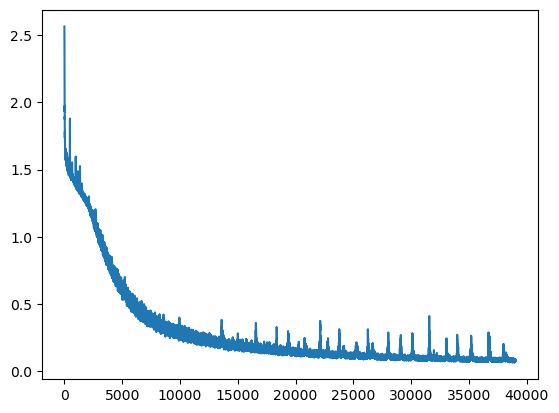

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

print('loss')
plt.plot(program.losses, label='loss')
plt.legend
plt.show()